In [7]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jit
from jax.scipy.stats import norm

# split method
from sklearn.linear_model import LassoCV

import pandas as pd
from run_scripts.load_data import load_traintest_sparsereg
from conformal_bayes import conformal_Bayes_functions as cb
from conformal_bayes import Bayes_MCMC_functions as bmcmc
%reload_ext autoreload
%autoreload 2

In [8]:
#Load Data
dataset = 'diabetes'
#dataset = 'boston'
seed = 100
B = 2000

train_frac = 0.7
x,y,x_test,y_test,y_plot,n,d = load_traintest_sparsereg(train_frac,dataset,seed)


### Check ESS

In [9]:
from theano import tensor as tt
import pymc3 as pm

#Horseshoe
def fit_mcmc_laplace(y,x,B,seed = 100,misspec = False):
    with pm.Model() as model:
        p = np.shape(x)[1]

        #Laplace
        b = pm.Gamma('b',alpha = 1,beta = 1)
        beta = pm.Laplace('beta',mu = 0, b = b,shape = p)
        intercept = pm.Flat('intercept')

        if misspec == True:
            sigma = pm.HalfNormal("sigma", sigma = 0.02) ## misspec
        else:
            sigma = pm.HalfNormal("sigma", sigma = 1) 
        obs = pm.Normal('obs',mu = pm.math.dot(x,beta)+ intercept,sigma = sigma,observed=y)

        trace = pm.sample(B,random_seed = seed)
    return trace

In [10]:
#MCMC + check ESS
#No Misspec
trace = fit_mcmc_laplace(y,x,B,seed = seed,misspec = False)
pm.summary(trace).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, beta, b]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
/Users/efong/.local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.01,0.04,-0.09,0.07,0.0,0.0,10019.0,3674.0,10049.0,5706.0,1.0
beta[1],-0.10,0.05,-0.19,-0.02,0.0,0.0,9045.0,8311.0,9038.0,5521.0,1.0
beta[2],0.36,0.05,0.26,0.44,0.0,0.0,9505.0,9476.0,9526.0,5560.0,1.0
beta[3],0.18,0.05,0.09,0.26,0.0,0.0,9566.0,9305.0,9580.0,6277.0,1.0
beta[4],-0.14,0.14,-0.43,0.10,0.0,0.0,3793.0,2862.0,4278.0,3314.0,1.0
beta[5],-0.00,0.12,-0.23,0.24,0.0,0.0,4154.0,3307.0,4632.0,3719.0,1.0
beta[6],-0.06,0.08,-0.21,0.10,0.0,0.0,4872.0,4872.0,4929.0,4367.0,1.0
beta[7],0.04,0.08,-0.11,0.20,0.0,0.0,6854.0,4275.0,6988.0,5614.0,1.0
beta[8],0.37,0.08,0.23,0.52,0.0,0.0,5088.0,4685.0,5272.0,4535.0,1.0
beta[9],0.04,0.05,-0.05,0.13,0.0,0.0,8772.0,4766.0,8990.0,5091.0,1.0


In [11]:
#Misspec
trace_misspec = fit_mcmc_laplace(y,x,B,seed = seed,misspec = True)
pm.summary(trace_misspec).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, beta, b]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
/Users/efong/.local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.01,0.03,-0.06,0.04,0.0,0.0,9226.0,4850.0,9235.0,6011.0,1.0
beta[1],-0.12,0.03,-0.17,-0.06,0.0,0.0,7879.0,7686.0,7883.0,6072.0,1.0
beta[2],0.36,0.03,0.30,0.41,0.0,0.0,8039.0,8039.0,8050.0,5599.0,1.0
beta[3],0.18,0.03,0.13,0.24,0.0,0.0,6397.0,6301.0,6393.0,5258.0,1.0
beta[4],-0.27,0.15,-0.55,-0.00,0.0,0.0,1958.0,1740.0,2086.0,2277.0,1.0
beta[5],0.09,0.13,-0.13,0.33,0.0,0.0,2038.0,1832.0,2166.0,2495.0,1.0
beta[6],-0.02,0.07,-0.15,0.12,0.0,0.0,2423.0,2423.0,2539.0,2854.0,1.0
beta[7],0.05,0.06,-0.06,0.16,0.0,0.0,6057.0,4640.0,6162.0,5407.0,1.0
beta[8],0.42,0.07,0.30,0.55,0.0,0.0,2365.0,2220.0,2509.0,2647.0,1.0
beta[9],0.04,0.03,-0.02,0.10,0.0,0.0,7180.0,6109.0,7188.0,5783.0,1.0


In [15]:
#Compute conformal interval
beta_post = jnp.array(trace['beta'])
intercept_post = jnp.array(trace['intercept'].reshape(-1,1))
sigma_post = jnp.array(trace['sigma'].reshape(-1,1))

alpha = 0.2
rep = np.shape(beta_post)[0]
n_test = np.shape(x_test)[0]

coverage_cp = np.zeros(n_test)
length_cp = np.zeros(n_test)
region_cp = np.zeros((n_test,np.shape(y_plot)[0]))
ESS = np.zeros((n_test,np.shape(y_plot)[0],1))
Var = np.zeros((n_test,np.shape(y_plot)[0],1))

j = 0
seed = 100 + j
x,y,x_test,y_test,y_plot,n,d = load_traintest_sparsereg(train_frac,dataset,seed)
y_plot = np.linspace(-7,4,100)
dy = y_plot[1] - y_plot[0]

@jit
def normal_loglikelihood(y,x):
    return norm.logpdf(y,loc = jnp.dot(beta_post,x.transpose())+ intercept_post,scale = sigma_post) #compute likelihood samples

logp_samp_n = normal_loglikelihood(y,x)
logwjk = normal_loglikelihood(y_plot.reshape(-1,1,1),x_test)
logwjk_test = normal_loglikelihood(y_test,x_test).reshape(1,-1,n_test)

In [16]:
#Compute conformal interval
beta_post = jnp.array(trace_misspec['beta'])
intercept_post = jnp.array(trace_misspec['intercept'].reshape(-1,1))
sigma_post = jnp.array(trace_misspec['sigma'].reshape(-1,1))

alpha = 0.2
rep = np.shape(beta_post)[0]
n_test = np.shape(x_test)[0]

coverage_cp = np.zeros(n_test)
length_cp = np.zeros(n_test)
region_cp = np.zeros((n_test,np.shape(y_plot)[0]))
ESS_misspec = np.zeros((n_test,np.shape(y_plot)[0],1))
Var_misspec = np.zeros((n_test,np.shape(y_plot)[0],1))

j = 0
seed = 100 + j
x,y,x_test,y_test,y_plot,n,d = load_traintest_sparsereg(train_frac,dataset,seed)
y_plot = np.linspace(-7,4,100)
dy = y_plot[1] - y_plot[0]

@jit
def normal_loglikelihood(y,x):
    return norm.logpdf(y,loc = jnp.dot(beta_post,x.transpose())+ intercept_post,scale = sigma_post) #compute likelihood samples

logp_samp_n_misspec = normal_loglikelihood(y,x)
logwjk_misspec = normal_loglikelihood(y_plot.reshape(-1,1,1),x_test)
logwjk_test_misspec = normal_loglikelihood(y_test,x_test).reshape(1,-1,n_test)

In [19]:
#well spec
i = 1
alpha_range= np.array([0.2,0.5])
n_alph = np.shape(alpha_range)[0]
region_cp = np.zeros((n_alph,np.shape(y_plot)[0]))
ind_band = np.zeros((n_alph,2),dtype = 'int')
for a in range(n_alph):
    region_cp[a] = cb.compute_cb_region_IS(alpha_range[a],logp_samp_n,logwjk[:,:,i])
    ind_band[a] = np.where(np.diff(region_cp[a])!=0)[0]
    
#Compute ESS from IS weightss
ESS[i], Var[i] = cb.diagnose_is_weights(logp_samp_n,logwjk[:,:,i])
ESS_ratio = 3793/np.shape(beta_post)[0] 

#misspec
n_alph = np.shape(alpha_range)[0]
region_cp_misspec = np.zeros((n_alph,np.shape(y_plot)[0]))
ind_band_misspec = np.zeros((n_alph,2),dtype = 'int')
for a in range(n_alph):
    region_cp_misspec[a] = cb.compute_cb_region_IS(alpha_range[a],logp_samp_n_misspec,logwjk_misspec[:,:,i])
    ind_band_misspec[a] = np.where(np.diff(region_cp_misspec[a])!=0)[0]
    
#Compute ESS from IS weightss
ESS_misspec[i], Var_misspec[i] = cb.diagnose_is_weights(logp_samp_n_misspec,logwjk_misspec[:,:,i])
ESS_ratio_misspec = 1958/np.shape(beta_post)[0] #misspec

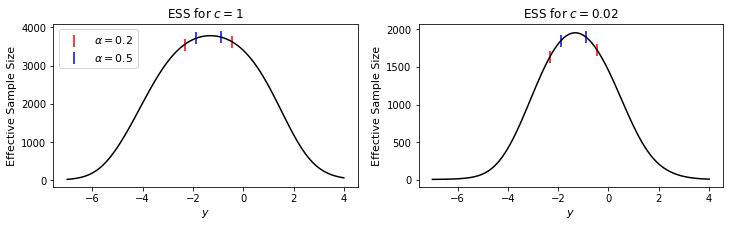

In [23]:
f = plt.figure(figsize = (12,3))
plt.subplot(1,2,1)
plt.plot(y_plot,ESS[i]*ESS_ratio,color = 'k')
colors = ['red','blue']
for a in range(n_alph):
    plt.scatter(y_plot[ind_band[a]],ESS[i,ind_band[a]]*ESS_ratio, color = colors[a],marker = '|',s = 150,\
            label = r'$\alpha = {}$'.format(alpha_range[a]))
plt.ylabel('Effective Sample Size',fontsize = 11)
plt.xlabel('$y$',fontsize = 11)
plt.legend(loc= 2,fontsize = 11)
plt.title(r'ESS for $c = 1$')

plt.subplot(1,2,2)
plt.plot(y_plot,ESS_misspec[i]*ESS_ratio_misspec,color = 'k')
colors = ['red','blue']
for a in range(n_alph):
    plt.scatter(y_plot[ind_band_misspec[a]],ESS_misspec[i,ind_band_misspec[a]]*ESS_ratio_misspec, color = colors[a],marker = '|',s = 150,\
            label = r'$\alpha = {}$'.format(alpha_range[a]))
plt.ylabel('Effective Sample Size',fontsize = 11)
plt.xlabel('$y$',fontsize = 11)
plt.title(r'ESS for $c = 0.02$')
f.savefig('plots/ESS_var_misspec.pdf', bbox_inches='tight')